## False Coloring Introduction 


#### Purpose
Render grayscale digital pathology datasets into virtual H&E color space for 3D pathology. This notebook is used to describe some of the main features of the FalseColor python package, and view the results. The main processing application of this package is color_script.py located in the scripts folder. 

#### Using this notebook

##### GPU processing
With GPU processing there are a few more pre processing steps that occur, which happen implicitly in the CPU version.
NOTE: for using the non-flat field based fc.rapidFalseColor method additional background subtraction is unneeded.

##### No intensity leveling
1. Background levels are calculated and subtracted from both channels and image levels are clipped to the range of 0-65535.
2. Edges are enhanced using the sharpenImage method in coloring.py
3. The images are false colored using the rapidFalseColor method from coloring.py

##### With intensity leveling
1. Background levels are calculated and subtracted from both channels and image levels are clipped to the range of 0-65535.
2. Edges are enhanced using the sharpenImage method in coloring.py
3. The intensity leveling map for each channel is calculated and resized
4. The images are false colored using the rapidFalseColor method from coloring.py


In [1]:
import FalseColor.coloring as fc
from FalseColor.process import ViewImage
import numpy as np
import os
%matplotlib notebook
import matplotlib.pyplot as plt
import h5py as h5
import scipy.ndimage as nd
from numba import cuda
import math
import skimage as sk
import cv2
import copy
import time

In [2]:
#load example data
lung_datapath = 'h5_sample_data/lung'
lung_datafile = os.path.join(lung_datapath,'lung_data.h5')
lung_h5 = h5.File(lung_datafile,'r')

In [3]:
#get individual channels
lung_nuclei = lung_h5['t00000']['s00']['0']['cells'][:].astype(float)
lung_cyto = lung_h5['t00000']['s01']['0']['cells'][:].astype(float)
print(lung_nuclei.shape)

(17, 1024, 1024)


<IPython.core.display.Javascript object>


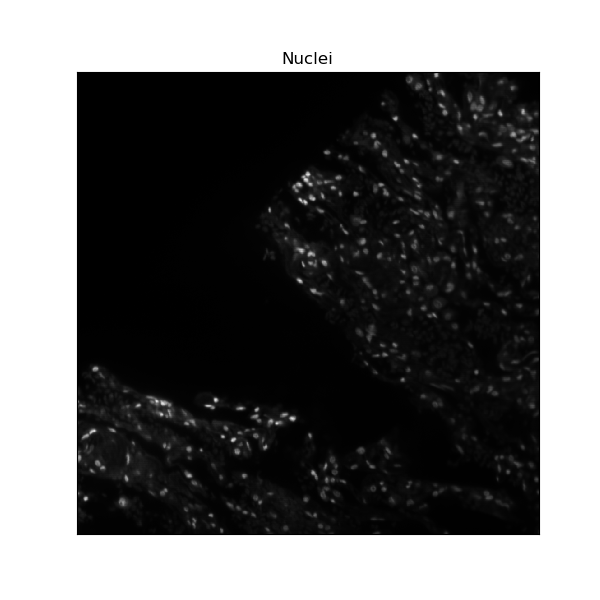

<IPython.core.display.Javascript object>


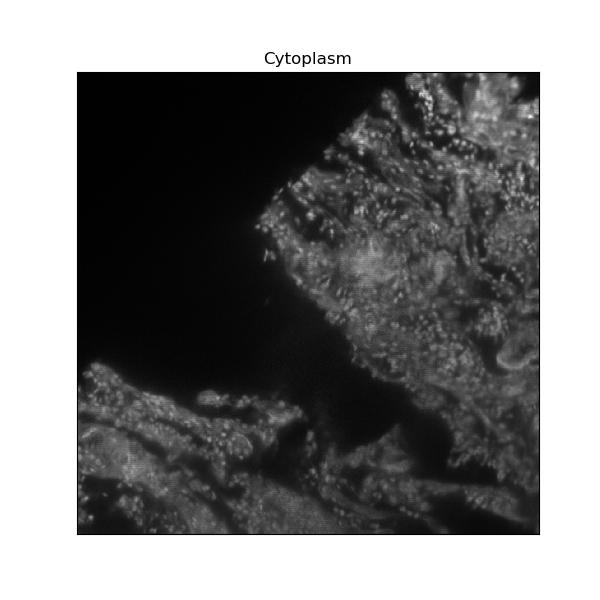

(<Figure size 600x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x245c95280d0>)

In [4]:
#View raw data
ViewImage(lung_nuclei[0], title = 'Nuclei', figsize = (6,6), cmap = 'gray')
ViewImage(lung_cyto[0], title = 'Cytoplasm', figsize = (6,6), cmap = 'gray')

In [5]:
#Get RGB color settings for H&E false coloring
settings_dict = fc.getColorSettings(key = 'HE')
nuclei_RGBsettings = settings_dict['nuclei']
cyto_RGBsettings = settings_dict['cyto']

In [6]:
#execute GPU accelerated false coloring on two individual images using standard background subtraction
example_nuclei = copy.deepcopy(lung_nuclei[0])
example_cyto = copy.deepcopy(lung_cyto[0])

sharpened_nuclei = fc.sharpenImage(example_nuclei)
sharpened_cyto = fc.sharpenImage(example_cyto)

pseudo_lung = fc.rapidFalseColor(sharpened_nuclei, sharpened_cyto, nuclei_RGBsettings, cyto_RGBsettings,
                                       run_FlatField_cyto = False, run_FlatField_nuc = False,
                                       cyto_normfactor = 1200, 
                                       nuc_normfactor = 9000)


<IPython.core.display.Javascript object>


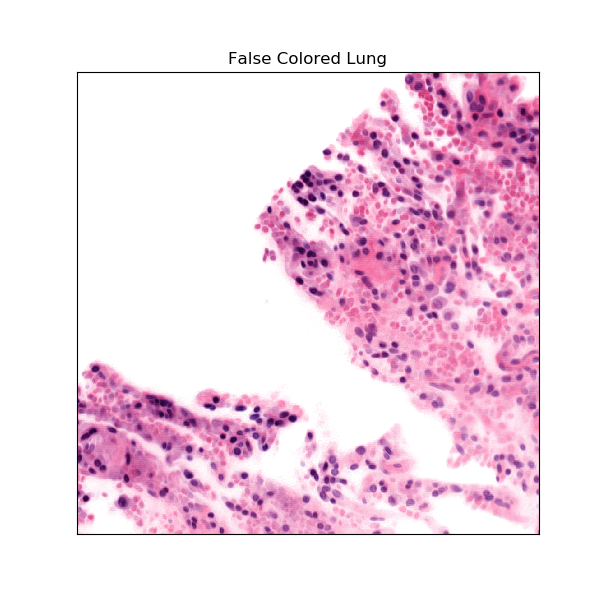

(<Figure size 600x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2308d38c100>)

In [7]:
#View Result
ViewImage(pseudo_lung, title='False Colored Lung',figsize=(6,6))


Below will use the flat fielding method, the non default option for fc.rapidFalseColor


In [8]:
# subtract background from images
nuclei_nobackground = np.zeros(lung_nuclei.shape)
cyto_nobackground = np.zeros(lung_cyto.shape)

for i in range(len(lung_nuclei)):
    nuc_bg = fc.getBackgroundLevels(lung_nuclei[i])[1]
    cyto_bg = fc.getBackgroundLevels(lung_cyto[i])[1]
    
    nuc_img = copy.deepcopy(lung_nuclei[i]) - nuc_bg
    nuc_img[nuc_img < 0] = 0
    
    cyto_img = copy.deepcopy(lung_cyto[i]) - cyto_bg
    cyto_img[cyto_img < 0] = 0
    
    nuclei_nobackground[i] = nuc_img
    cyto_nobackground[i] = cyto_img

In [9]:
#Calculate intensity leveling map from background subtracted data
nuc_flatfield = fc.getFlatField(nuclei_nobackground)[0]
cyto_flatfield = fc.getFlatField(cyto_nobackground)[0]

In [10]:
#upsample flat fields to be the correct shape
nuc_flatfield = nd.interpolation.zoom(nuc_flatfield[0], 16, order = 1, mode = 'nearest')
cyto_flatfield = nd.interpolation.zoom(cyto_flatfield[0], 16, order = 1, mode = 'nearest')
nuc_flatfield.shape

(1024, 1024)

In [11]:
#Sharpen Images
sharp_nuclei = np.zeros(nuclei_nobackground.shape)
sharp_cyto = np.zeros(cyto_nobackground.shape)

for i in range(len(sharp_nuclei)):
    sharp_nuclei[i] = fc.sharpenImage(nuclei_nobackground[i])
    sharp_cyto[i] = fc.sharpenImage(cyto_nobackground[i])

In [12]:
#get RGB settings for H&E false coloring
settings_dict = fc.getColorSettings()

In [13]:
#execute false coloring for whole dataset using intensity leveling
pseudo_colored = []
tstart = time.time()
for i in range(len(lung_nuclei)):
    pseudo_colored.append(fc.rapidFalseColor(sharp_nuclei[i], sharp_cyto[i], nuclei_RGBsettings, cyto_RGBsettings,
                                            run_FlatField_nuc = True, run_FlatField_cyto = True,
                                            nuc_normfactor = nuc_flatfield,
                                            cyto_normfactor = 3*cyto_flatfield))
print(time.time()-tstart)

1.744002103805542


<IPython.core.display.Javascript object>


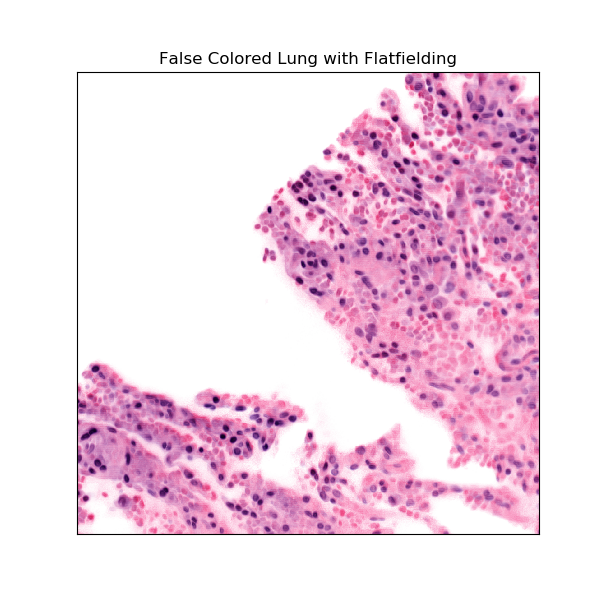

(<Figure size 600x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x230af0115e0>)

In [14]:
ViewImage(pseudo_colored[0],title = 'False Colored Lung with Flatfielding', figsize=(6,6))